# A reconstruction nosie dependence on CMB white noise level
This code compute normalization and power spectrum of quadratic estiamtors with varying CMB noise level

In [1]:
# external
import numpy as np
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import constant as c
import cmb

First define parameters

In [2]:
Lmin, Lmax  = 2, 4096       # maximum multipole of output normalization
rlmin, rlmax = 2, 4096  # CMB multipole range for reconstruction
dlmin, dlmax = 2, 4096    # lensing template
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)

Load arrays of CMB unlensed and lensed Cls. Unlensed Cls are not used for now. The Cls should not be multiplied by any factors and should not have units.  

In [3]:
# ucl is an array of shape [0:5,0:rlmax+1] and ucl[0,:] = TT, ucl[1,:] = EE, ucl[2,:] = TE, lcl[3,:] = phiphi, lcl[4,:] = Tphi
ucl = cmb.read_camb_cls('../data/unlensedcls.dat',ftype='scal',output='array')[:,:rlmax+1] # TT, EE, TE, pp, Tp
# lcl is an array of shape [0:4,0:rlmax+1] and lcl[0,:] = TT, lcl[1,:] = EE, lcl[2,:] = BB, and lcl[3,:] = TE
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:rlmax+1] # TT, EE, BB, TE

Loop over SNR calculation

In [4]:
sigs = [6.,5.,4.,3.,2.,1.,.5,.3,.1] # pol noise
Ag0, Ag1 = {}, {}
for i, sig in enumerate(sigs):
    nl  = np.zeros((4,rlmax+1))
    nl[0,:] = .5*(sig*c.ac2rad/c.Tcmb)**2
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    ocl = lcl + nl
    Ag0[i] = cs.norm_quad.qeb('lens',Lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])[0]
    Ag1[i] = cs.norm_quad.qeb_iter(Lmax,rlmax,rlmin,rlmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:],ucl[3,:],iter=50)[0]

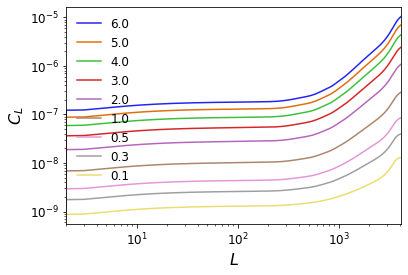

In [5]:
pl.plot_1dstyle(xmin=2,xmax=Lmax)
for i in range(len(sigs)):
    loglog(L,L**4*Ag1[i],label=str(sigs[i]))
legend()

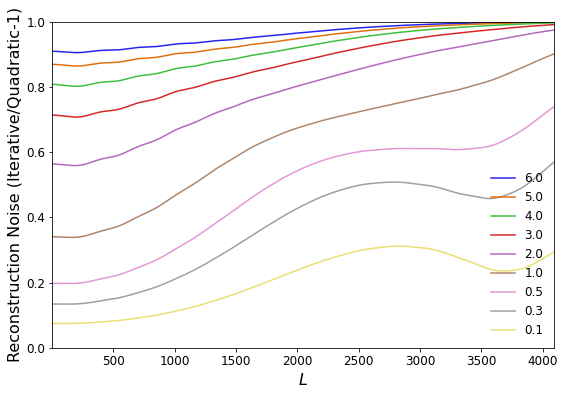

In [6]:
pl.plot_1dstyle(fsize=[9,6],ymin=0,ymax=1.,xmin=2,xmax=Lmax,ylab='Reconstruction Noise (Iterative/Quadratic-1)')
for i in range(len(sigs)):
    plot(L[2:],Ag1[i][2:]/Ag0[i][2:],label=str(sigs[i]))
legend()

In [7]:
LT = {}
for i in range(len(sigs)):
    WE = np.ones((dlmax+1))
    Wp = ucl[3,:]/(ucl[3,:]+Ag1[i])
    LT[i] = basic.delens.lintemplate(dlmax, dlmin, dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1], WE, Wp[:dlmax+1])

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [8]:
bb = basic.delens.lensingbb(dlmax, dlmin, dlmax, lcl[1,:dlmax+1], ucl[3,:dlmax+1])

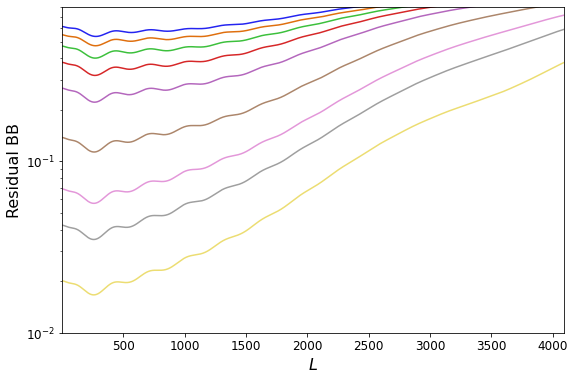

In [9]:
pl.plot_1dstyle(ymin=.01,ymax=.8,xmin=2,xmax=dlmax,ylog=True,ylab='Residual BB')
for i in range(len(sigs)):
    plot(L[2:dlmax+1],1-LT[i][2:]/bb[2:])